In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Image
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit import Chem

# Fragment Error Analysis

Date: January 11, 2021
## Objectives
Identify fragment impact on molecular property prediction errors.  Minimize contributions from ubiquitous fragments such as `ccc`.

### Approach
1. Split molecules into "easy to predict" and "hard to predict"
    1. Top and bottom quartiles of property prediction error
    2. This should be **dataset specific**.  Molecules or fragments that are difficult to predict for one
      property may not be difficult for the next.  These effects will offset in an average error.
      

2. Compare and contrast fragments from these groups. Are the most common (by number of appearances) the same?

3. Remove highly conserved fragments (present in both in easy and hard populations). 


4. Identify which fragments are most significant based on relationship counts and relationship error weights.


5.  Analyze results.

### Grouping Molecules by Error Prediction Error
I need to collect statistics on molecules average prediction errors.  For simplicity and minimizing variables,
I am going to just use the `Lipophilicity-ID` dataset.  

**Make a difficulty property based on molecule predictions.**  This will be used to categorize molecules as hard to predict.  In the below query, I do not used the `scaled average error` because I am only looking at a single dataset.  This is not ideal since I am writing directly to the molecule node, which may be a part of more than one dataset.
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[]-(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)
WITH avg(p.average_error) as difficulty, M, T, p
SET M.difficulty = difficulty
RETURN M,T, p
```

**Find the difficult to predict molecules.**  This query will find the molecules above the 90th percentile.  In other words, the 10% of molecules with the highest average error.
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WHERE M.difficulty > cutoff
RETURN  id(M) as NodeID, M.smiles as SMILES , M.difficulty as Difficulty, cutoff ORDER BY
M.difficulty DESC LIMIT 100
```

**Find the most common fragments.** We want to subtract the most common fragments in the bottom 90% from the fragments in the top 10% most difficult molecules.  But first we must identify what fragments are most common.

**Most common fragments in easy molecules**
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff, count(M) as total
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE M.difficulty < cutoff
RETURN F.name, count(f), 0.9 * total as Total, toFloat(count(f)) / 0.9 / total * 100 as percent ORDER BY count(f) DESC LIMIT 100
```
**Most common fragments in hard molecules**
```cypher
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff, count(M) as total
MATCH (D:DataSet{data:'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WHERE M.difficulty > cutoff
RETURN F.name, count(f), 0.1 * total as Total, toFloat(count(f)) / 0.1 / total * 100 as percent ORDER BY count(f) DESC LIMIT 100
```

The above Cypher command finds the most frequent fragments in the group based on number of relationships it has to molecules in the dataset.  It calculates the percent of molecules in that group that have that fragment.

### Removing fragments that overlap molecular groups
Next we need to find what fragments are common in both the high error and less error sets.  Then isolate the ones more frequent in the high error group.

I think there are several ways we could go about making rules for which fragments to remove.

1. We could remove the `n` most common fragments in the easy group from the hard group.

2. Remove fragments with a prevelence above a threshold, say 25%.  i.e if a fragment is present in 25% or more of the easy molecules, remove it.

3. We could remove fragments that have the same prevelence (within a threshold, say 2%) in both the hard and easy sets.

4. Remove all fragments present in the easy group from the hard group.  This will remove the most and leave fragments that *only* exist in the hard group.

Let's start with the first approach.

```cypher
// Remove Common Fragments
MATCH (D:DataSet{data: 'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff

MATCH (D:DataSet{data: 'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(eM:Molecule)-[ef:HAS_FRAGMENT]->(eF:Fragment)
WHERE eM.difficulty < cutoff // easy molecules
WITH eF, count(ef) as efreq, cutoff // gath frags and frequency
ORDER BY efreq DESC LIMIT 1000  //  limit to top n
WITH  collect(eF) as easyFrags, cutoff

MATCH (D:DataSet{data: 'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(hM:Molecule)-[hf:HAS_FRAGMENT]->(hF:Fragment)
WHERE hM.difficulty > cutoff // hard molecules
WITH hF, count(hf) as hfreq, easyFrags
ORDER BY hfreq DESC LIMIT 1000
WITH collect(hF) as hardFrags, easyFrags

// use APOC to do list intersect & subtraction
WITH apoc.coll.intersection(easyFrags, hardFrags) as overlap, apoc.coll.subtract(hardFrags, easyFrags) as remain 

// Find Molecule-Fragment pairs that have the remaining fragments and are in the dataset
UNWIND remain as rFrags
MATCH (D:DataSet{data: 'Lipophilicity-ID.csv'})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(rFrags)
WITH M, rFrags
MATCH (M)-[f:HAS_FRAGMENT]->(rFrags)

// Get Difficulty Stats for Remaining Fragments
WITH rFrags.name as fragment, count(f) as number_of_rel, sum(f.difficulty) as sum_difficulty,sum(f.difficulty)/count(f) as avg_difficulty// , M, rFrags,f 
RETURN fragment, number_of_rel, sum_difficulty, avg_difficulty
ORDER BY number_of_rel DESC, avg_difficulty DESC               
```

#  Fragment Analysis Procedure
Ideally, we would be able to calculate molecule `difficulty` on the fly when running the analysis.   A user may want to know what fragments are difficult for a particular chemical property, such as logP.  In this scenario, the `difficulty` property should only consider logP errors.  But then we have a user-query specific property persisting in the mother graph, which is undesired.  My less than elegant solution is as follows:
1. Remove all `difficulty` weights
2. Make new `difficulty` weights for the chemical property of interest
3. Run Fragment Analysis
4. Remove the `difficulty` weights

## Streamlined Cypher Commands
Cypher commands can be run in Batch using `;` to separate the commands, but the outputs will be suppressed.  So the command that returns your results should be run by itself.  These first 3 commands can be run together, however. They remove old weights, set the dataset of interest, and create new weights for use with the analysis.  

### 1. Prepare Graph
```cypher
// Delete old weights
MATCH (M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
REMOVE M.difficulty, f.difficulty                      
RETURN M, F, f;

// Set a parameter for the  Dataset you are interested in
// so you change it in one place only.
:param data => "Lipophilicity-ID.csv"; // must be in separate command from MATCH

// Make new weights for Dataset
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WITH avg(p.average_error) as difficulty, f, M, F
SET M.difficulty = difficulty                      
SET f.difficulty = difficulty
RETURN M, F, f;
```
### 2. Run Fragment Analysis
The command below produces the fragment analysis and returns the number of relationships, the sum of their errors and the average error.

```cypher
// Remove Common Fragments
MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(M:Molecule)
WITH  percentileCont(M.difficulty, 0.90) as cutoff

MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(eM:Molecule)-[ef:HAS_FRAGMENT]->(eF:Fragment)
WHERE eM.difficulty < cutoff // easy molecules
WITH eF, count(ef) as efreq, cutoff // gath frags and frequency
ORDER BY efreq DESC LIMIT 1000  //  limit to top n
WITH  collect(eF) as easyFrags, cutoff

MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(hM:Molecule)-[hf:HAS_FRAGMENT]->(hF:Fragment)
WHERE hM.difficulty > cutoff // hard molecules
WITH hF, count(hf) as hfreq, easyFrags
ORDER BY hfreq DESC LIMIT 1000
WITH collect(hF) as hardFrags, easyFrags

// use APOC to do list intersect & subtraction
WITH apoc.coll.intersection(easyFrags, hardFrags) as overlap, apoc.coll.subtract(hardFrags, easyFrags) as remain 

// Find Molecule-Fragment pairs that have the remaining fragments and are in the dataset
UNWIND remain as rFrags
MATCH (D:DataSet{data: $data})-[c:CONTAINS_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(rFrags)
WITH M, rFrags
MATCH (M)-[f:HAS_FRAGMENT]->(rFrags)

// Get Difficulty Stats for Remaining Fragments
WITH rFrags.name as fragment, count(f) as number_of_rel, sum(f.difficulty) as sum_difficulty,sum(f.difficulty)/count(f) as avg_difficulty// , M, rFrags,f 
RETURN fragment, number_of_rel, sum_difficulty, avg_difficulty
ORDER BY number_of_rel DESC, avg_difficulty DESC                                                       
```
### 3. Clean up
***RUN THIS AT THE END to clean up after yourself!***

```cypher
// Delete weights again
MATCH (D:DataSet{data: $data})-[:SPLITS_INTO_TEST]->(T:TestSet)-[p:CONTAINS_PREDICTED_MOLECULE]->(M:Molecule)-[f:HAS_FRAGMENT]->(F:Fragment)
WITH avg(p.average_error) as difficulty, f, M, F
REMOVE M.difficulty = difficulty                      
REMOVE f.difficulty = difficulty
RETURN M, F, f LIMIT 20;
```

## A Fragment Analysis Case Study for LogP
While running the above analysis for the `Lipophilicity-ID.csv` dataset, I encountered an irregularity that resulted in what I think is an interesting example of how this graph database is useful. I want to document it and this seems like a decent place for now. 

### The Fragment Analysis Results
Upon running the fragment analysis, I saved the Cypher results as a CSV. The Cypher query sorts the fragments first by the number of incoming relationships, i.e how many molecules have that fragment and then by the average prediction difficulty.  The results are below.

In [2]:
path = '/home/adam/research/neo4j/cypher/'
frags = pd.read_csv(path + 'Frag_Analysis_lipoID.csv')
frags

,fragment,number_of_rel,sum_difficulty,avg_difficulty
0,cc<-X>cNC,68,5.230488e+01,0.769189
1,ccnc[nH],67,5.157731e+01,0.769811
2,c<=O>nCc,67,4.938120e+01,0.737033
3,ccC<=O>C,65,4.125765e+06,63473.300050
4,CCCC<-O>,65,4.937961e+01,0.759686
...,...,...,...,...
196,CCN(c)S(<=O>)<=O>,16,1.959603e+01,1.224752
197,cNC<=O>Nc,16,1.853962e+01,1.158726
198,cc<-X>ccC<=O>,16,1.757039e+01,1.098149
199,ccc(c<-OMe>)S(<=O>)<=O>,15,1.913052e+01,1.275368


These results look pretty normal. Except for that fragment that has **huge** difficulty values.  I then sorted by average difficulty as the primary sort key.

In [3]:
frags.sort_values(by="avg_difficulty", ascending=False).head(15)

,fragment,number_of_rel,sum_difficulty,avg_difficulty
176,CC<=O>OC,27,4.125751e+06,152805.587743
165,CC<=O>O,30,4.125754e+06,137525.143215
139,C<=O>NC(C)C<=O>,37,4.125748e+06,111506.693103
128,CC[C@@H](C<=O>)N,39,4.125749e+06,105788.431380
114,CCCCC<=O>,41,4.125754e+06,100628.138366
106,CCC<-N>,43,4.125756e+06,95947.815838
107,CCC<-C(=O)O>,43,4.125746e+06,95947.589936
62,c<-N>cC<=O>,54,4.125763e+06,76403.011438
48,CC<-N>,57,4.125768e+06,72381.886109
12,cccC<=O>C,63,4.125763e+06,65488.298270


This view shows astronomical difficulty values and then instant drop off.  This indicated to me that a small number of molecule(s) were the culprit and likely the large errors were caused by some models that were totally haywire.  The next step was to track the errors to the source.

### Finding the Source of the Error
The above results are for fragments, but fragments inherit their `difficulty` from the parent molecules.  So I wrote a Cypher query to rank molecules by their `difficulty`. 

```cypher
MATCH (D:DataSet{data: $data})-[:CONTAINS_MOLECULE]->(M:Molecule)
WHERE EXISTS (M.difficulty)
WITH M.smiles as SMILES, M.difficulty as Difficulty, id(M) as Node_ID
RETURN DISTINCT SMILES, Difficulty, Node_ID
ORDER BY Difficulty DESC LIMIT 100
```

The results are below:

In [4]:
mols = pd.read_csv(path + 'Molecule_diff_lipoID.csv')
mols.head(10)

,SMILES,Difficulty,Node_ID
0,CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N...,4.125720e+06,11205
1,CC(N)(COP(=O)(O)O)C(=O)O,3.334416e+00,9995
2,Cc1oc(CN2CCNCC2)cc1C(=O)NCC12CC3CC(CC(C3)C1)C2,3.242000e+00,11514
3,CN(C)c1ccc2nc3ccc(=[N+](C)C)cc-3sc2c1,3.177085e+00,10507
4,N#Cc1ccc(-c2csc(Nc3ccc(O)cc3)n2)cc1,3.148000e+00,9108
5,NCc1ccc(NC(=O)c2cc(Nc3ncccn3)c3cc(/C(N)=N/O)cc...,3.143136e+00,9616
6,COCCCOc1ccnc(C[S+]([O-])c2nc3ccccc3[nH]2)c1C,3.141442e+00,11022
7,COCCNCc1ccc(CCNC[C@H](O)c2ccc(O)c3[nH]c(=O)sc2...,3.049231e+00,8433
8,COc1ccc(-c2nc3c(NCCCNC(=O)c4ccccc4)c(Br)cnc3[n...,2.943623e+00,10397
9,O=C(O)c1ccc2cccc(O)c2n1,2.890912e+00,9533


The results show that a single molecule is responsible for the huge fragment `difficulty`.  With the SMILES and Node ID in hand, I can visualize the molecule and find it in the graph to explore its connections. 

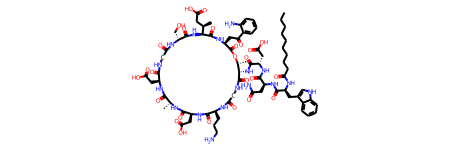

In [5]:
Chem.MolFromSmiles(mols.at[0, "SMILES"])

In [6]:
print(mols.at[0, "SMILES"])

CCCCCCCCCC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H]1C(=O)NCC(=O)N[C@@H](CCCN)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@H](C)C(=O)N[C@@H](CC(=O)O)C(=O)NCC(=O)N[C@H](CO)C(=O)N[C@@H]([C@H](C)CC(=O)O)C(=O)N[C@@H](CC(=O)c2ccccc2N)C(=O)O[C@@H]1C


### Exploring Further in the Graph Database
The above molecule is the one that causes massive errors and that makes plenty of sense since it is such a complex molecule. So chemical intuition is satisfied that this molecule might cause problems.  Now to find it in the graph and explore its context.  This could be done with either Bloom or the Browser, but I prefer exploring in Bloom when I can.  I had wrote a custom query for Bloom to execute which will find molecules by their SMILES (no node ID necessary). Screenshot below:

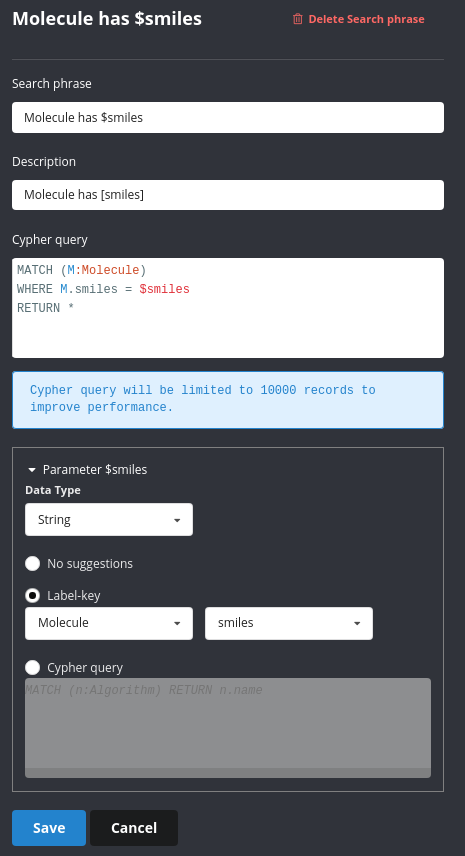

In [7]:
Image(filename='/home/adam/Pictures/Screenshots/bloom_query_smiles.png') 

This search enables simple searching in Neo4j Bloom by simpling typing `Molecule has "your_SMILES"`.  The search yielded the singular molecule node, which I then expanded to show all related `TestSet` nodes, which enables me to see the `CONTAINS_PREDICTED_MOLECULE` relationships (where the prediction values and errors are stored).

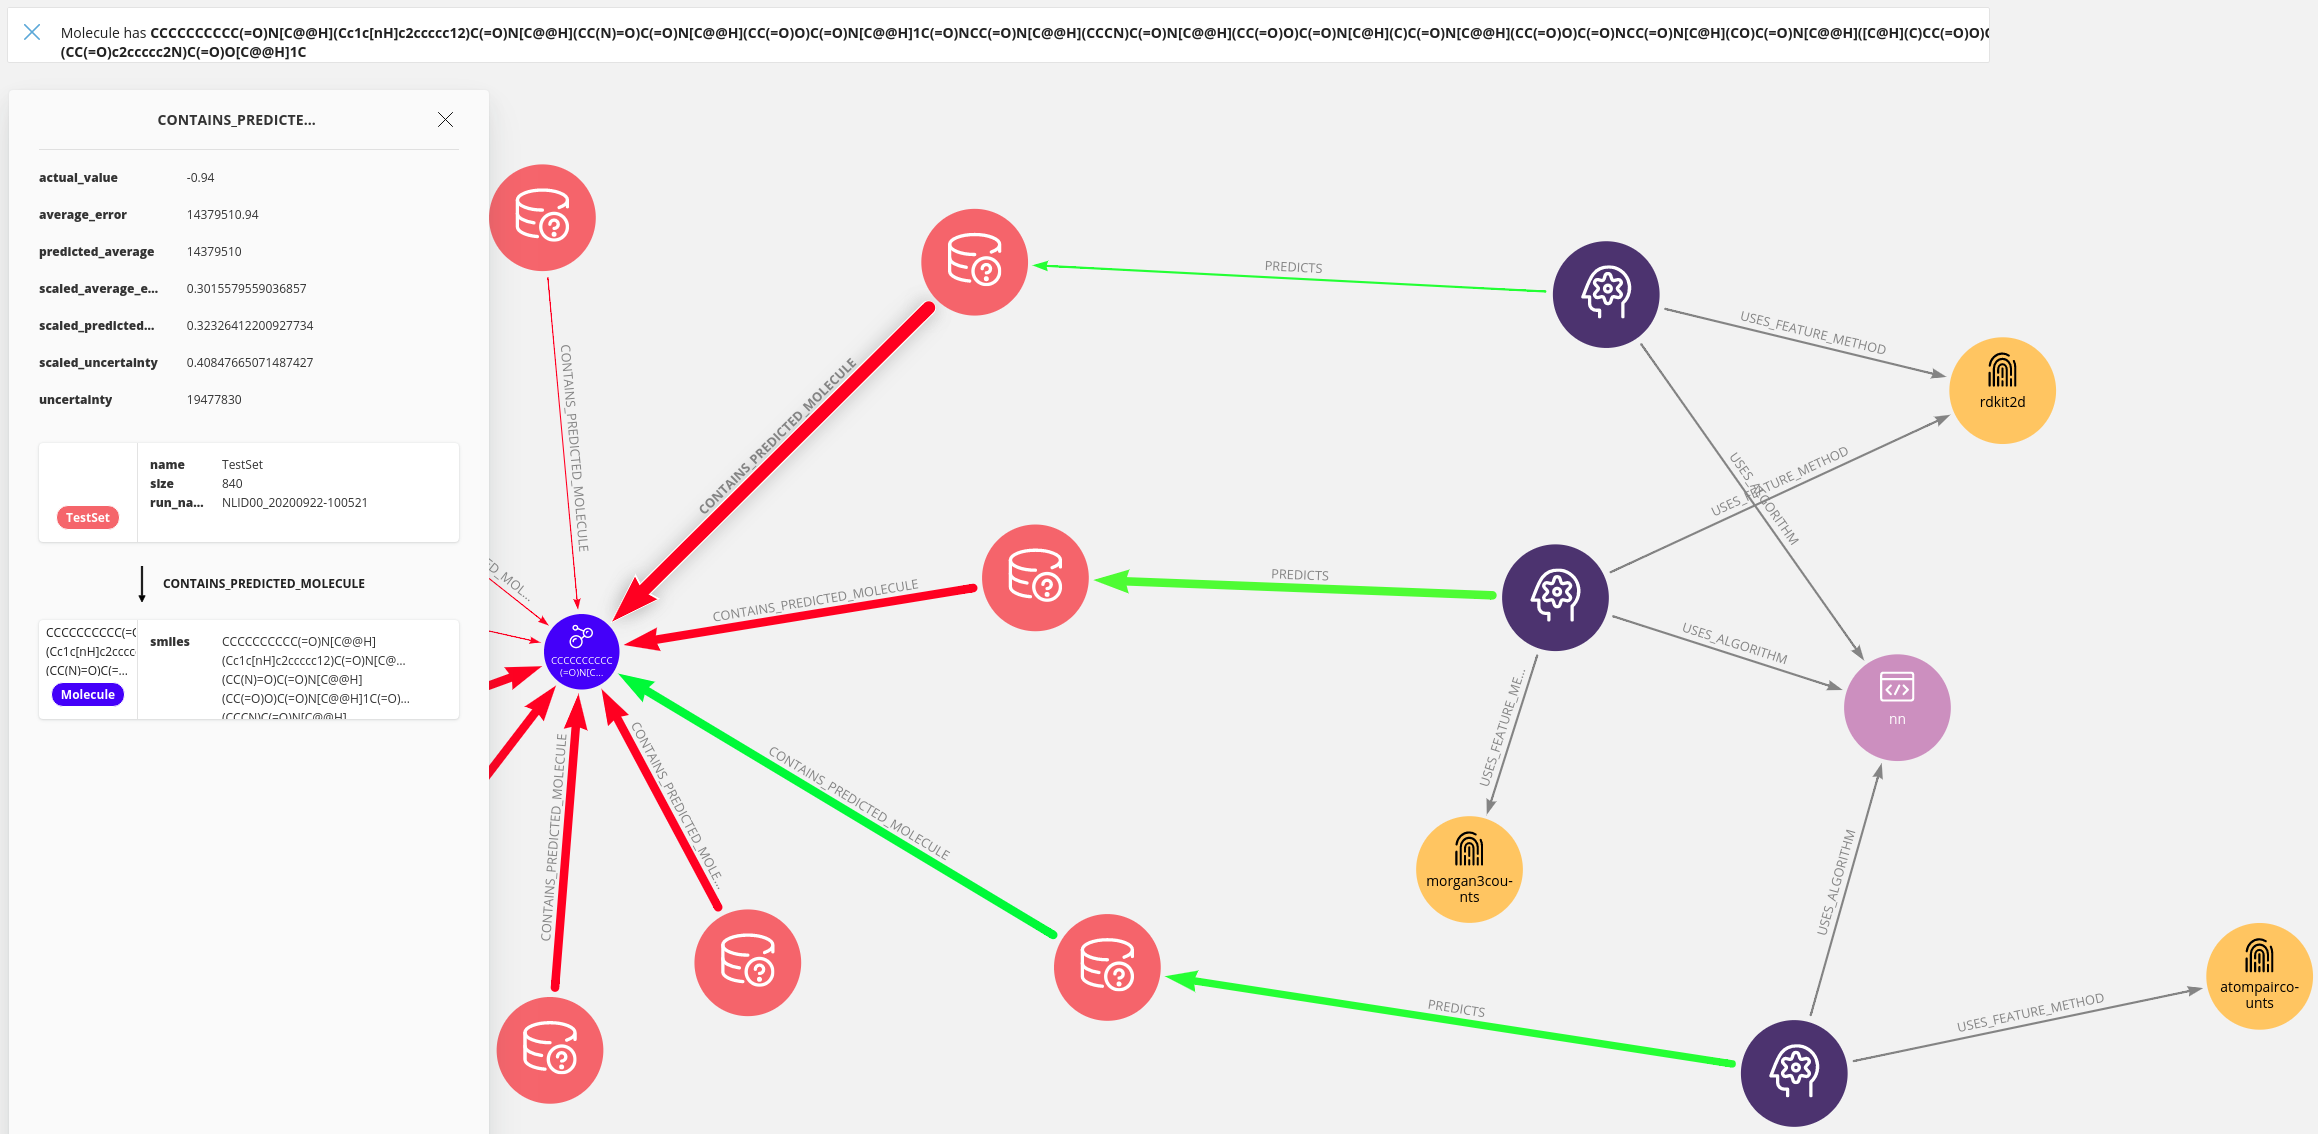

In [8]:
Image(filename='/home/adam/Pictures/Screenshots/macro-graph.png') 

This view allows me to see how many models have predicted logP for this molecule (10) and how well each model performed.  It turns out two models had the astronomical values, 7 had bad but relatively reasonable predictions, and a single model did okay.  I was interested in the 2 terrible models and the alright model, so I expanded the those nodes to show what `Algorithm` and `FeaturizationMethod` they used.  

As can be seen in the above image, all 3 models of interest were neural networks.  The two horrid models used `rdkit2d` featurization and one of them also used `morgan3counts`.  The good model used `atompaircounts` featurization method.  

### Unique Findings

Further expanding the models that predict the troublesome macro-cycle show that the one model that predicts it well is not only unique in its performance but also  in its combination of algorithm and featurization method.  The performant model is the only model to use a neural network and `atompaircounts`.  Models that use a neural network but a different featurization method do not perform as well.  Similarly, models that use `atompaircounts` and other learning algorithms do not perform well.  

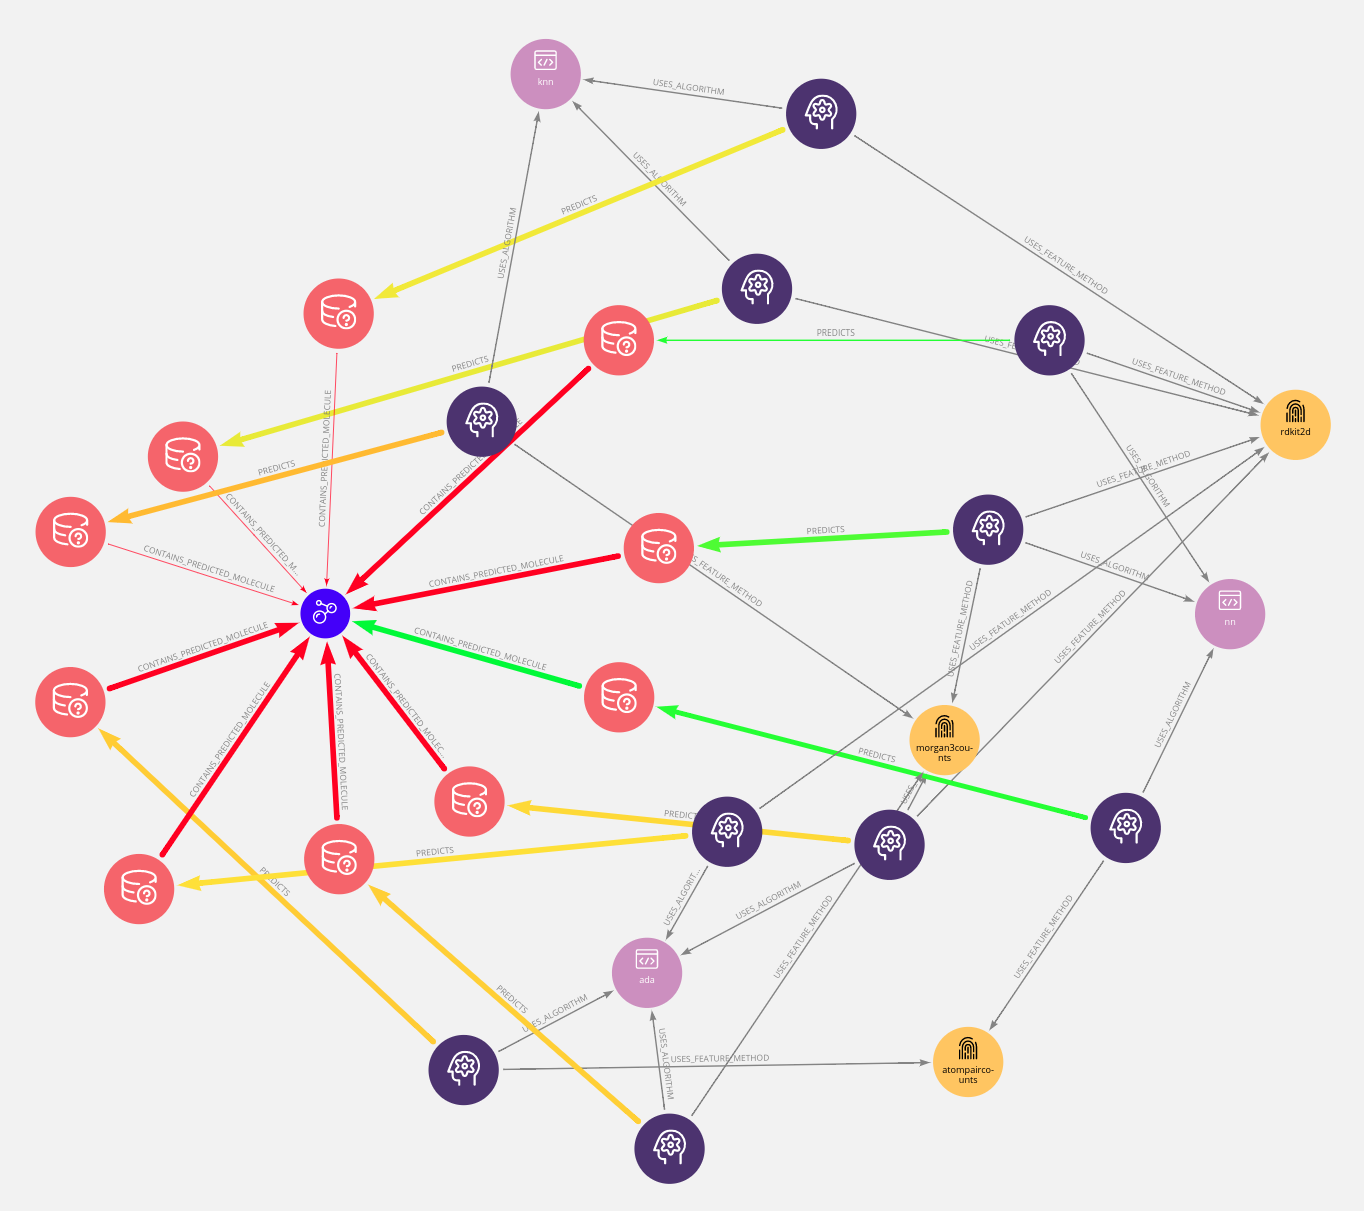

In [9]:
Image(filename='/home/adam/Pictures/Screenshots/macro-fullgraph.png') 

### Case Study Conclusion
In this case study, I asked "What molecular fragments cause error when predicting logP?".  I used the graph database to design and execute a rather complex query to rank molecular fragments based upon their frequency in tough-to-predict molecules.  The query returned anomolous results.  I then queried the graph database to find the source of the anomoly.  Once the source, a structually complex molecule, was identified, a simple graph query was used to locate the molecule in the graph visualization tool (Bloom).  Bloom was then used to further explore the context around the anomoly.  

This whole process, from recognizing the issue in the fragment analysis to exploring the graph around the problematic molecule was quick -- maybe 25 minutes.  Moreover, I only used Python and Neo4j for the entire process.  The efficiency is possible because of the connected structure of the graph database.  The same analysis is likely possible with other relational databases structures, but would likely lack the speed, ease, visualizations possible by Neo4j's property graph database.  